# Vertical Bin Packing Problem

- Airport and Cargo Operations (AE4446)
- Zach Kelly (), Timotei Dudas ()
- May 5th, 2023

### Imports

In [818]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gurobipy as gp
from gurobipy import Model, GRB, GurobiError, quicksum, LinExpr
import pickle

### Input Data

In [819]:
# load data 
ulds = pd.read_pickle('../data/B.pickle')
items = pd.read_pickle('../data/R.pickle')

print('----- ULDs -----')
display(ulds)
print('----- Items -----')
display(items)

----- ULDs -----


{0: (0, [300, 155, 2, 140, 0, 0, 0]),
 1: (0, [300, 155, 2, 140, 0, 0, 0]),
 2: (1, [192, 155, 2, 200, 0, 0, 0]),
 3: (1, [192, 155, 2, 200, 0, 0, 0])}

----- Items -----


{0: (98, 50, 1, 0, 0, 0),
 1: (89, 46, 1, 0, 0, 0),
 2: (64, 24, 1, 0, 0, 0),
 3: (93, 29, 1, 1, 0, 0),
 4: (114, 54, 1, 1, 0, 0),
 5: (95, 60, 1, 0, 0, 0),
 6: (63, 28, 1, 0, 0, 0),
 7: (100, 46, 0, 0, 0, 0),
 8: (52, 61, 1, 0, 0, 0),
 9: (45, 46, 1, 0, 0, 0),
 10: (111, 32, 1, 0, 0, 0),
 11: (109, 38, 1, 0, 1, 0),
 12: (97, 57, 1, 0, 0, 0),
 13: (51, 29, 1, 0, 0, 0),
 14: (86, 54, 1, 0, 0, 0),
 15: (114, 31, 1, 1, 0, 0),
 16: (81, 47, 1, 0, 0, 0),
 17: (78, 25, 1, 0, 0, 0),
 18: (78, 44, 1, 0, 0, 0),
 19: (68, 33, 1, 0, 0, 0),
 20: (51, 45, 1, 0, 0, 0),
 21: (84, 36, 1, 0, 0, 1),
 22: (66, 35, 0, 0, 0, 0),
 23: (68, 42, 1, 1, 0, 0),
 24: (108, 57, 1, 1, 1, 0)}

In [820]:
# toy data
'''
ulds = {0: (0, [300, 155, 2, 140, 0, 0, 0]),1: (0, [300, 155, 2, 140, 0, 0, 0])}

items = {0: (98, 50, 1, 0, 0, 0),
 1: (89, 46, 1, 0, 0, 0),
 2: (64, 24, 1, 0, 0, 0),
 3: (93, 29, 1, 1, 0, 0),
 4: (114, 54, 1, 1, 0, 0),
 5: (95, 60, 1, 0, 0, 0),
 6: (63, 28, 1, 0, 0, 0),
 7: (100, 46, 0, 0, 0, 0)}
'''

### Setup Model

In [821]:
print('Creating Model')
print('--------------------')
model = Model()

Creating Model
--------------------


### Model Parameters 

In [822]:
# total number of items to be packed
n = len(items.keys())
# total number of available ULDs
m = len(ulds.keys())
# dimensions of items
li = [items[i][0] for i in range(n)] # length
hi = [items[i][1] for i in range(n)] # height
# dimensions of ULDs 
lc = [ulds[j][1][0] for j in range(m)]
hc = [ulds[j][1][1] for j in range(m)]
# find largest uld length and width
Lj_max = np.max(np.array(list(dict(ulds.values()).values()))[:,0])
Hj_max = np.max(np.array(list(dict(ulds.values()).values()))[:,1])
# rotatabilty of items
vi = [items[i][2] for i in range(n)]
# fragility of items
fi = [items[i][3] for i in range(n)]
# perishablity of items
pi = [items[i][4] for i in range(n)]
# radioactivity of items
ri = [items[i][5] for i in range(n)]
# cost of containers
Cj = [ulds[j][1][3] for j in range(m)]

### Model Variables

In [823]:
print('Creating Decision Variables')
print('--------------------')

### define decision variables ###

p_ij = {} # if item i is in ULD j 

for i in range(n):
    for j in range(m):
        p_ij[i,j]=model.addVar(lb=0, ub=1, vtype=GRB.BINARY,name="p_ij[%s,%s]"%(i,j))

u_j = {} # if container j is used 
for j in range(m):
    u_j[j] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="u_j[%s]"%(j))

x_i = {} # x location of lower left corner of item i
z_i = {} # z location of lower left corner of item i
x_i_ = {} # x location of upper right corner of item i
z_i_ = {} # z location of upper right corner of item i 

for i in range(n):
    x_i[i] = model.addVar(lb=0, ub=Lj_max, vtype=GRB.CONTINUOUS, name="x_i[%s]"%(i))
    x_i_[i] = model.addVar(lb=0, ub=Lj_max, vtype=GRB.CONTINUOUS, name="x_i_[%s]"%(i))
    z_i[i] = model.addVar(lb=0, ub=Hj_max, vtype=GRB.CONTINUOUS, name="z_i[%s]"%(i))
    z_i_[i] = model.addVar(lb=0, ub=Hj_max, vtype=GRB.CONTINUOUS, name="z_i_[%s]"%(i))

r_i11 = {} # if length is along x axis 
r_i13 = {} # if height is along x axis 
r_i31 = {} # if length is along z axis 
r_i33 = {} # if height is along z axis 

for i in range(n):
    r_i11[i] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="r_i11[%s]"%(i))
    r_i13[i] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="r_i13[%s]"%(i))
    r_i31[i] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="r_i31[%s]"%(i))
    r_i33[i] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="r_i33[%s]"%(i))

xp_ik = {} # if item i is to the right of item k 
zp_ik = {} # if item i is above item k 

for i in range(n):
    for k in range(n):
        if i != k:
            xp_ik[i,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="xp_ik[%s,%s]"%(i,k))
            zp_ik[i,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="zp_ik[%s,%s]"%(i,k))
            
r_iab = {} # if side b of item i is along axis a 

for i in range(n):
    for a in range(0,2):
        for b in range(0,2):
            r_iab[i,a,b] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="r_iab[%s,%s,%s]"%(i,a,b))

g_i = {} # if item i is on the ground

for i in range(n):
    g_i[i] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="g_i[%s]"%(i))

h_ik = {} # if box k has a suitable height to support box i

for i in range(n):
    for k in range(i+1,n):
        h_ik[i,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="h_ik[%s,%s]"%(i,k))

o_ik = {} # if the projection of the items i and k onto the x plane have a nonempty intersection

for i in range(n):
    for k in range(i+1,n):
        o_ik[i,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="o_ik[%s,%s]"%(i,k))

s_ik = {} # 1 if item k supports item i and are in the same container

for i in range(n):
    for k in range(n):
        s_ik[i,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="s_ik[%s,%s]"%(i,k))

n_ik1 = {} # if left side of item k is less than or equal to item i

for i in range(n):
    for k in range(i+1,n):
        n_ik1[i,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="n_ik1[%s,%s]"%(i,k))

n_ik3 = {} # if right side of item i is less than or equal to item k

for i in range(n):
    for k in range(i+1,n):
        n_ik3[i,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="n_ik3[%s,%s]"%(i,k))

b_ikl = {} # if vertex l of item i is supported by item k

for i in range(n):
    for k in range(n):
        if i != k:
            for l in range(1,3):
                b_ikl[i,k,l] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="b_ikl[%s,%s,%s]"%(i,k,l))

v_ik = {} # represents |z_i_[k]-z_i[i]|

for i in range(n):
    for k in range(i+1,n):
        v_ik[i,k] = model.addVar(lb=0,ub=Hj_max, vtype=GRB.CONTINUOUS, name="v_ik[%s,%s]"%(i,k))

m_ik = {} # if z_i_[k] >= z_i[i]

for i in range(n):
    for k in range(i+1,n):
        m_ik[i,k] = model.addVar(lb=0,ub=1, vtype=GRB.BINARY, name="m_ik[%s,%s]"%(i,k))

c_j = {} # if container j is compatible with radioactive items 

for j in range(m):
    c_j[j] = model.addVar(lb=0,ub=1, vtype=GRB.BINARY, name="c_j[%s]"%(j))

model.update()     

Creating Decision Variables
--------------------


### Model Constraints

In [824]:
print('Creating Constraints')
print('--------------------')

#usage
for i in range(n):
    for j in range(m):
        lhs = LinExpr()
        lhs = p_ij[i,j]-u_j[j]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=0, name='usage_bin_item[%s,%s]'%(i,j))

# item i is constrained to single uld j (4)
for i in range(n):
    lhs = LinExpr()
    for j in range(m):
        lhs += p_ij[i,j]
    model.addConstr(lhs=lhs, sense=GRB.EQUAL, rhs=1, name='constraint_4')

# the horizontal position of each item i is constrained by the length of the container j (5)
for i in range(n):
    lhs = LinExpr()
    for j in range(m):    
        lhs += lc[j]*p_ij[i,j]
    model.addConstr(lhs=lhs, sense=GRB.GREATER_EQUAL, rhs=x_i_[i], name='constraint_5')

# the vertical position of each item i is constrained by the height of the container j (7)
for i in range(n):
    lhs = LinExpr()
    for j in range(m):
        lhs += hc[j]*p_ij[i,j]
    model.addConstr(lhs=lhs, sense=GRB.GREATER_EQUAL, rhs=z_i_[i], name='constraint_7')

# item length is length or height (8 & 10)
for i in range(n):
    lhs = LinExpr()
    lhs = x_i_[i]-x_i[i]
    model.addConstr(lhs=lhs, sense=GRB.EQUAL, rhs=r_iab[i,0,0]*li[i] + r_iab[i,0,1]*hi[i], name='constraint_8')
    lhs = LinExpr()
    lhs = z_i_[i]-z_i[i]
    model.addConstr(lhs=lhs, sense=GRB.EQUAL, rhs=r_iab[i,1,0]*li[i] + r_iab[i,1,1]*hi[i], name='constraint_10')

# side b of item i must only be along 1 axis a (11)
for i in range(n):
    for b in range(0,2):
        lhs = LinExpr()
        for a in range(0,2):
            lhs += r_iab[i,a,b]
        model.addConstr(lhs=lhs, sense=GRB.EQUAL, rhs=1, name='constraint_11')

# axis a must only be along 1 side b of item i (12)
for i in range(n):
    for a in range(0,2):
        lhs = LinExpr()
        for b in range(0,2):
            lhs += r_iab[i,a,b]
        model.addConstr(lhs=lhs, sense=GRB.EQUAL, rhs=1, name='constraint_12')   

## No Overlap Constraints ##
# ensure no overlap of items i in container j (13, 14, 15 & 18)

# items cannot overlap if they're in the same container
for i in range(n):
    for k in range(n):
        if i < k:
            lhs = LinExpr()
            lhs = xp_ik[i,k]+zp_ik[i,k]
            for j in range(m):
                rhs = LinExpr()
                rhs = p_ij[i,j]+p_ij[k,j]-1
                model.addConstr(lhs=lhs, sense=GRB.GREATER_EQUAL, rhs=rhs, name='constraint_13')
                
# if item i is to the right of item k then x_i[i] >= x_i_[k]
for i in range(n): 
    for k in range(n):
        if i != k:
            lhs = LinExpr()
            lhs = x_i_[k]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=x_i[i]+(1-xp_ik[i,k])*Lj_max, name='constraint_14') 
# if item i is the left of item k then x_i_[k] >= x_i[i]
for i in range(n):
    for k in range(n):
        if i != k:
            lhs = LinExpr()
            lhs = x_i[i]+1
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=x_i_[k]+xp_ik[i,k]*Lj_max, name='constraint_15')

for i in range(n):
    for k in range(n):
        if i != k:
            lhs = LinExpr()
            lhs = z_i_[k]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=z_i[i]+(1-zp_ik[i,k])*Hj_max, name='constraint_17')

for i in range(n):
    for k in range(n):
        if i != k:
            lhs = LinExpr()
            lhs = z_i[i]+1
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=z_i_[k]+zp_ik[i,k]*Hj_max, name='constraint_18')

## Orientation Constraints ##
# if length of box can be in a vertical orientation (19)
for i in range(n):
    lhs = LinExpr()
    lhs = r_i31[i]
    model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=vi[i], name='constraint_19')

## Stability Constraints ##
# item i must have 2 vertices supported by another item k if not supported by the ground (26)
for i in range(n):
    for k in range(n):
        if i != k:
            for l in range(1,3):
                lhs += 2*g_i[i] + b_ikl[i,k,l]

    model.addConstr(lhs=lhs, sense=GRB.GREATER_EQUAL, rhs=2, name='constraint_26_modified')
    lhs = LinExpr()

# if lower vertex z_i of item i is on the ground then z_i[i] must equal 0 (27)
for i in range(n):
    lhs = LinExpr()
    lhs = z_i[i]
    model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=(1-g_i[i])*Hj_max, name='constraint_27')

# define variable h_ik using v_ik where v_ik = |z_i_[k] - z_i[i]| (28-33)
for i in range(n):
    for k in range(i+1,n):
        lhs = LinExpr()
        lhs = z_i_[k]-z_i[i]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=v_ik[i,k], name='constraint_28')
        lhs = LinExpr()
        lhs = z_i[i]-z_i_[k]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=v_ik[i,k], name='constraint_29')
        lhs = LinExpr()
        lhs = v_ik[i,k]
        # case when z_i_[k] - z_i[i] >= 0
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=z_i_[k]-z_i[i]+2*Hj_max*(1-m_ik[i,k]), name='constraint_30')
        # case when z_i_[k] - z_i[i] < 0
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=z_i[i]-z_i_[k]+2*Hj_max*m_ik[i,k], name='constraint_31')
        lhs = LinExpr()
        lhs = h_ik[i,k]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=v_ik[i,k], name='constraint_32')
        lhs = LinExpr()
        lhs = v_ik[i,k]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=h_ik[i,k]*Hj_max, name='constraint_33')

# if item i and k projections dont overlap on the x-dimension then 1 <= 1 <= 1 (34)
# if item k supports item i and are in the same container then k must have suitable hieght to support i and their projections overlap (35)
for i in range(n):
    for k in range(n):
        if i < k:
            lhs = LinExpr()
            lhs = o_ik[i,k]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=xp_ik[i,k]+xp_ik[k,i], name='constraint_34')
            lhs = LinExpr()
            lhs = xp_ik[i,k]+xp_ik[k,i]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=o_ik[i,k], name='constraint_34')

            lhs = LinExpr()
            lhs = 1-s_ik[i,k]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=h_ik[i,k]+o_ik[i,k], name='constraint_35')
            lhs = LinExpr()
            lhs = h_ik[i,k]+o_ik[i,k]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=2*(1-s_ik[i,k]), name='constraint_35')

# if item k supports item i and are in the same bin then they must be in the same bin j (36 & 37)
for i in range(n):
    for k in range(i+1,n):
        for j in range(m):
            lhs = LinExpr()
            lhs = p_ij[i,j] - p_ij[k,j]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=1-s_ik[i,k], name='constraint_36')
            lhs = LinExpr()
            lhs = p_ij[k,j] - p_ij[i,j]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=1-s_ik[i,k], name='constraint_37')

# if vertex l of item i is supported by item k then item k must support item i and be in the same container j (38)

for i in range(n):
    for k in range(i+1,n):
        for l in range(1,3):
            lhs = LinExpr()
            lhs = b_ikl[i,k,l]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=s_ik[i,k], name='constraint_38')

# if vertex l is supported the then n_ikl must be equal to 0 (39 & 40)
for i in range(n):
    for k in range(i+1,n):
        lhs = LinExpr()
        lhs = n_ik1[i,k]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=(1-b_ikl[i,k,1]), name='constraint_39')
        lhs = LinExpr()
        lhs = n_ik3[i,k]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=(1-b_ikl[i,k,2]), name='constraint_40')

# define n_ikl (43 & 45)
for i in range(n):
    for k in range(i+1,n):
        lhs = LinExpr()
        lhs = x_i[k]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=x_i[i]+n_ik1[i,k]*Lj_max, name='constraint_43')
        lhs = LinExpr()
        lhs = x_i_[i]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=x_i_[k]+n_ik3[i,k]*Lj_max, name='constraint_45')

# if item k is fragile then it cannot support item i (51)
for k in range(n):
    lhs = LinExpr()
    for i in range(n):
        if i != k:
            lhs += s_ik[i,k]
    model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=n*(1-fi[k]), name='constraint_51')

# perishable and radioactive items cannot be in the same container j (52)
for j in range(m):
    lhs = LinExpr()
    for i in range(n):
        perishable = LinExpr()
        perishable += pi[i]*p_ij[i,j]
        radioactive = LinExpr()
        radioactive += ri[i]*p_ij[i,j]
    
    # if there are radioactive items in container j there cannot be any perishable items in container j.
    model.addConstr(lhs=perishable, sense=GRB.LESS_EQUAL, rhs=n*(1-c_j[j]), name='constraint_52')   
    # if there are perishable items in container j there cannot be any radioactive items in container j.
    model.addConstr(lhs=radioactive, sense=GRB.LESS_EQUAL, rhs=n*c_j[j], name='constraint_52')

model.update()

Creating Constraints
--------------------


### Model Objective

In [825]:
print('Creating Objective')
print('--------------------')

# minimize the cost of packing all the items
obj = 0
for j in range(m):
    obj += Cj[j]*u_j[j]

model.setObjective(obj, GRB.MINIMIZE)

model.update()

Creating Objective
--------------------


### Export Model

In [826]:
model.write('2D_Vertical_BPP.lp')

### Solve

In [827]:
model.setParam('MIPGap',0.001)
model.setParam('TimeLimit',2*3600)
model.params.LogFile='2D_BPP.log'

model.optimize()

Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 7200
Set parameter LogFile to value "2D_BPP.log"
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 964 rows, 580 columns and 2893 nonzeros
Model fingerprint: 0x11e597d7
Variable types: 60 continuous, 520 integer (520 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 3e+02]
Presolve removed 343 rows and 274 columns
Presolve time: 0.01s
Presolved: 621 rows, 306 columns, 2032 nonzeros
Variable types: 60 continuous, 246 integer (246 binary)

Root relaxation: objective 1.400000e+02, 252 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

### Post Processing 

In [828]:
# get variable names and values
solution = []
for v in model.getVars():
    solution.append([v.varName,v.x])

solution = pd.DataFrame(solution)
solution.rename(columns={0:'Variable',1:'Value'})

solution.to_csv("solution.txt", header=None, index=None, sep='=', mode='w')

In [829]:
# Extract the results
bins_used = [j for j in ulds if quicksum(p_ij[i,j].X for i in items).getValue() > 0]
items_in_bin = {j: [i for i in items if p_ij[i,j].X > 0] for j in bins_used}
item_positions = {(i, j): (x_i[i].X, z_i[i].X) for j in bins_used for i in items_in_bin[j]}
item_info_solution = {i: [x_i[i].X, z_i[i].X, items[i][0]*r_iab[i,0,0].X+items[i][1]*r_iab[i,0,1].X, items[i][0]*r_iab[i,1,0].X+items[i][1]*r_iab[i,1,1].X] for i in items}

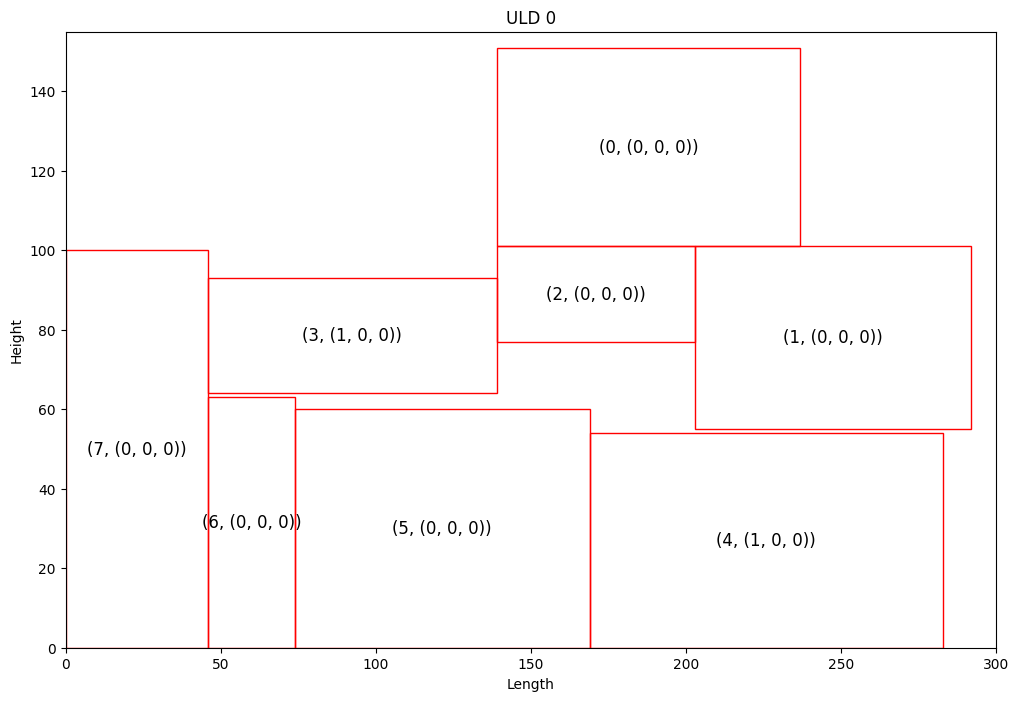

In [830]:
# Visualization function
def visualize_solution(items, ulds, items_in_bin, item_positions, fi, pi, ri):
    for j in ulds:
        if j in items_in_bin:
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.set_xlim(0, int(ulds[j][1][0]))
            ax.set_ylim(0, int(ulds[j][1][1]))

            for i in items_in_bin[j]:
                pos = item_positions[(i, j)]
                rect = patches.Rectangle(pos, items[i][0]*r_iab[i,0,0].X+items[i][1]*r_iab[i,0,1].X, items[i][0]*r_iab[i,1,0].X+items[i][1]*r_iab[i,1,1].X, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(pos[0] + (items[i][0]*r_iab[i,0,0].X+items[i][1]*r_iab[i,0,1].X) / 2, pos[1] + (items[i][0]*r_iab[i,1,0].X+items[i][1]*r_iab[i,1,1].X) / 2, f"{i,(fi[i],pi[i],ri[i])}", fontsize=12, ha="center", va="center")

            plt.title(f"ULD {j}")
            plt.xlabel('Length')
            plt.ylabel('Height')
            plt.show()

# Visualize the packed bins
visualize_solution(items, ulds, items_in_bin, item_positions, fi, pi, ri)

In [831]:
bins_used

with open('bins_used.pickle', 'wb') as file:
    pickle.dump(bins_used, file)

In [832]:
items_in_bin

with open('items_in_bin.pickle', 'wb') as file:
    pickle.dump(items_in_bin, file)


In [835]:
item_info_solution

with open('item_info_solution.pickle', 'wb') as file:
    pickle.dump(item_info_solution, file)

{0: [0, 1, 2, 4, 5, 9, 11, 18, 20],
 1: [3, 6, 8, 10, 14, 16, 19, 22, 24],
 3: [7, 12, 13, 15, 17, 21, 23]}